Mu is -> 0.015487112907364611
Sigma is -> 1.2441542517269004
Kurtosis is -> 10.114398493613322
Skewness is -> -0.7773915238540685


,SX5E,simplereturn,logreturn
Date,,,
2012-11-05,2517.669922,NaN,NaN
2012-11-06,2535.939941,0.725672,0.723051
2012-11-07,2479.100098,-2.241372,-2.266872
2012-11-08,2479.129883,0.001201,0.001201
2012-11-09,2479.820068,0.027840,0.027836
...,...,...,...
2013-03-26,2641.120117,-0.308005,-0.308480
2013-03-27,2612.459961,-1.085152,-1.091082
2013-03-28,2624.020020,0.442497,0.441521


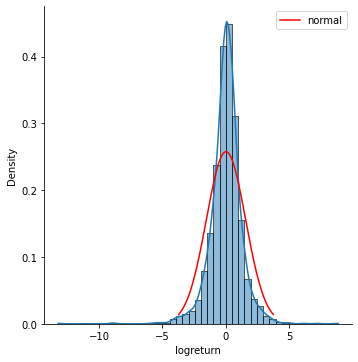

In [3]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import scipy.stats as ss
import statsmodels.api as sm #For acf plots
from arch.univariate import arch_model #We import the arch package to fit the time series model
from scipy.stats import skew, kurtosis, norm,t # to use the generalised Student-t pdf
from scipy.optimize import minimize #import minimize function from SciPy
#We upload the data
SX5Edata = pd.read_csv(r'C:\Users\Alberto\Documents\0 UNIVERSIDAD\MSC Imperial\qrm\QRM-2022-cw1-data-a.csv')#,header=0, parse_dates=[0], index_col=0)
SX5Edata['Date'] = pd.to_datetime(SX5Edata['Date'])
SX5Edata.set_index('Date', inplace=True)

#We create the simple and log returns in our panda frame
SX5Edata['simplereturn'] = SX5Edata['SX5E'].pct_change()
SX5Edata['logreturn'] = np.log(SX5Edata['SX5E']).diff()
#SX5Edata['logreturn'] = np.log(1 + SX5Edata['simplereturn'])

# Multiply the return values by 100 so they represent percentage values
SX5Edata['simplereturn']  = SX5Edata['simplereturn']  * 100
SX5Edata['logreturn'] = SX5Edata['logreturn'] * 100

#Calculation of parameters asked
mu = SX5Edata['logreturn'].mean()
sigma = SX5Edata['logreturn'].std()
skw = SX5Edata['logreturn'].skew()
kurt = SX5Edata['logreturn'].kurtosis()

#We create a list of points
x_values = np.linspace(mu-3*sigma,mu+3*sigma,1000)

# Add the plot of N(\mu,\sigma) pdf on top of the seaborn histogram
sns.displot(figsize = (10,10))
sns_ax = sns.histplot(data=SX5Edata['logreturn'], bins=45, stat="density", kde=True)
sns_ax.plot(x_values,norm.pdf(x_values,mu ,sigma**2),label="normal", color = 'red')
plt.legend()
print('Mu is ->', mu)
print('Sigma is ->', sigma)
print('Kurtosis is ->', kurt)
print('Skewness is ->', skw)
SX5Edata.head(100)

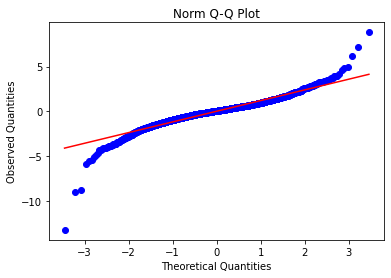

In [4]:
def qqplot(x, dist="norm"):
    fig, ax = plt.subplots(1,1)
    t, o = ss.probplot(x, dist=dist, plot=ax)
    title = f"{dist.title()} Q-Q Plot"
    
    min_ = min(t[0])
    max_ = max(t[0])
    
    ax.set_xlabel('Theoretical Quantities')
    ax.set_ylabel('Observed Quantities')
    ax.set_title(title)

    # ax.scatter(t[0],t[1])
    ax.plot((min_, min_), (max_,max_))
    
qqplot(SX5Edata['logreturn'].dropna())

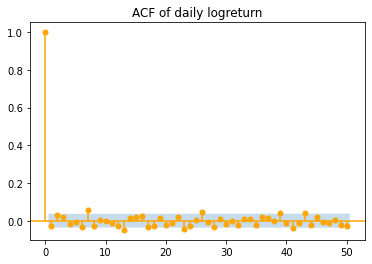

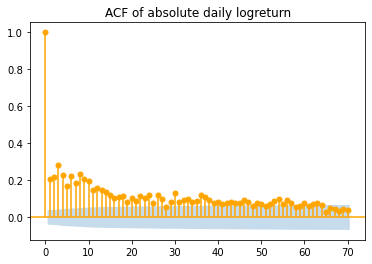

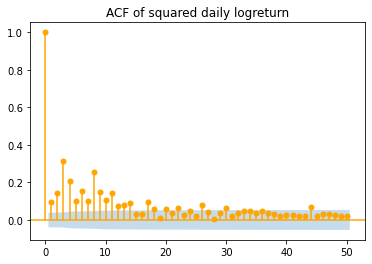

In [140]:
my_color = "orange"
sm.graphics.tsa.plot_acf(SX5Edata['logreturn'].dropna(),alpha=0.07, lags=50,color=my_color, vlines_kwargs={"colors": my_color},
                         title="ACF of daily logreturn")
plt.show()
sm.graphics.tsa.plot_acf(np.abs(SX5Edata['logreturn']).dropna(), lags=70,color=my_color, vlines_kwargs={"colors": my_color},
                         title="ACF of absolute daily logreturn")
plt.show()
sm.graphics.tsa.plot_acf((SX5Edata['logreturn'].dropna())**2, lags=50,color=my_color, vlines_kwargs={"colors": my_color},
                         title="ACF of squared daily logreturn")
plt.show()

In [50]:
pip install arch

Note: you may need to restart the kernel to use updated packages.


In [148]:
garchmodel = arch_model(SX5Edata['logreturn'].dropna(), mean='constant',rescale= 'True',p=1, q=1, dist='normal')
resgarch = garchmodel.fit(update_freq=5)
print(resgarch.summary())

Iteration:      5,   Func. Count:     37,   Neg. LLF: 3846.5235683315423
Iteration:     10,   Func. Count:     62,   Neg. LLF: 3747.517768495862
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3747.5177684965056
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              logreturn   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3747.52
Distribution:                  Normal   AIC:                           7503.04
Method:            Maximum Likelihood   BIC:                           7526.33
                                        No. Observations:                 2501
Date:                Wed, Nov 23 2022   Df Residuals:                     2500
Time:        

In [26]:
print(resgarch.conditional_volatility)
print(resgarch.params.mu)


Date
2012-11-06    0.996312
2012-11-07    0.970426
2012-11-08    1.245981
2012-11-09    1.162614
2012-11-12    1.087958
                ...   
2022-10-31    0.987944
2022-11-01    0.932934
2022-11-02    0.937769
2022-11-03    0.941033
2022-11-04    0.943918
Name: cond_vol, Length: 2501, dtype: float64
0.05859383990468475


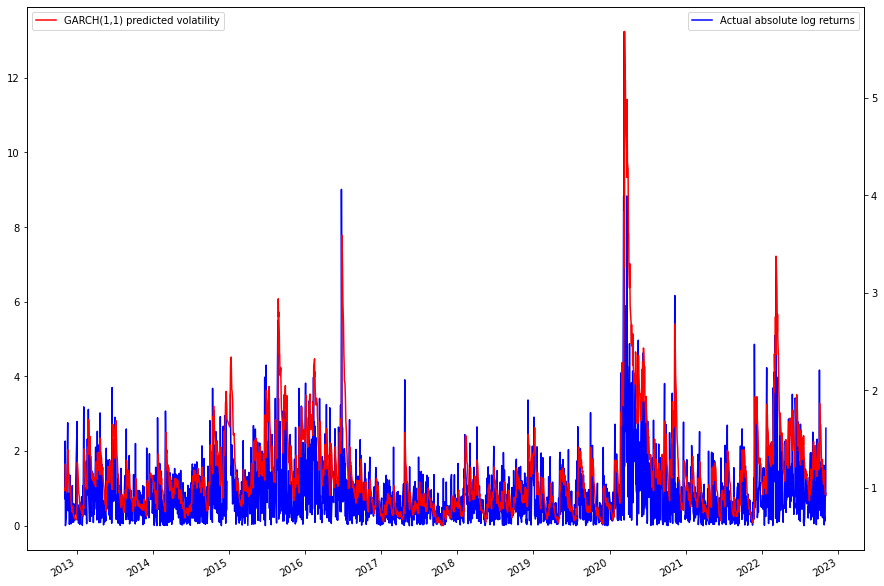

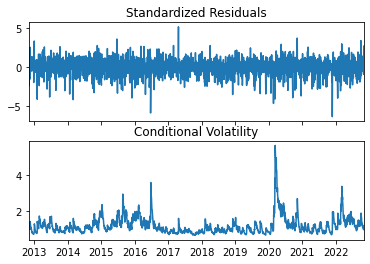

In [102]:
fig, ax1 = plt.subplots(figsize=(15,10))

ax2 = ax1.twinx()

ax1.plot(np.abs(SX5Edata['logreturn']), 'b', label='Actual absolute log returns')
ax2.plot(resgarch.conditional_volatility,c='r', label='GARCH(1,1) predicted volatility')

ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1)))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

for label in ax1.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax1.legend(loc=0); ax2.legend(loc=2)
resgarch.plot(); plt.show()

<class 'arch.univariate.base.ARCHModelResult'>


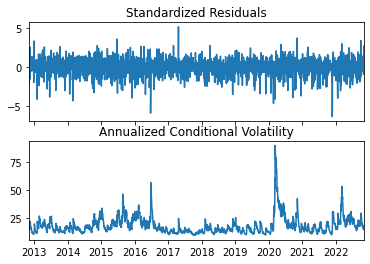

In [4]:
fig = resgarch.plot(annualize="D")
print(type(resgarch))

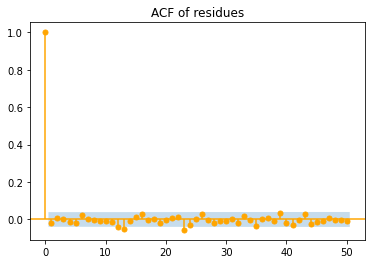

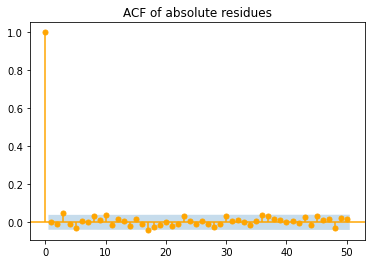

C:\Users\Alberto\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


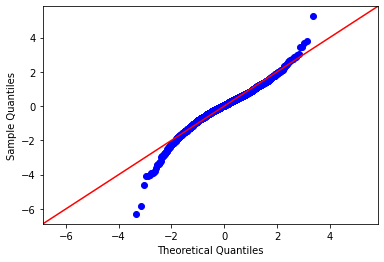

-0.05105017268241239
0.9993323377077566


In [23]:
sm.graphics.tsa.plot_acf(resgarch.std_resid, lags=50,color=my_color, vlines_kwargs={"colors": my_color},
                         title="ACF of residues")
plt.show()
sm.graphics.tsa.plot_acf(np.abs(resgarch.std_resid).dropna(), lags=50,color=my_color, vlines_kwargs={"colors": my_color},
                         title="ACF of absolute residues")
plt.show()

import statsmodels.api as sm

z = (resgarch.std_resid - resgarch.std_resid.mean())/resgarch.std_resid.std()  # remember to normalise the data against the mean and sd!
sm.qqplot(z, line='45') 
plt.show()

print(resgarch.std_resid.mean())
print(resgarch.std_resid.std())

In [ ]:
SX5Edata['unstresiduals'] = SX5Edata['logreturn'] - 

In [37]:
print(SX5Edata)

                   SX5E  simplereturn  logreturn
Date                                            
2012-11-05  2517.669922           NaN        NaN
2012-11-06  2535.939941      0.725672   0.723051
2012-11-07  2479.100098     -2.241372  -2.266872
2012-11-08  2479.129883      0.001201   0.001201
2012-11-09  2479.820068      0.027840   0.027836
...                 ...           ...        ...
2022-10-31  3617.540039      0.125104   0.125025
2022-11-01  3651.020020      0.925490   0.921234
2022-11-02  3622.010010     -0.794573  -0.797746
2022-11-03  3593.179932     -0.795969  -0.799154
2022-11-04  3688.330078      2.648076   2.613622

[2510 rows x 3 columns]


## Fitting an ARMA(1,1)-GARCH(1,1)-Student-t model

In the final example, we consider an ARMA(1,1)-GARCH(1,1) model 
\begin{align}
X_{t}&=\mu_t+\sigma_t Z_t,\\
\mu_t&=\mu+\phi_1(X_{t-1}-\mu)+\theta_1 (X_{t-1}-\mu_{t-1}),\\
\sigma_t^2&=\alpha_0+\alpha_1 (X_{t-1} - \mu_{t-1})^2 + \beta_1\sigma_{t-1}^2,
\end{align}
where $(Z_t)_t$ follows a normalised Student-t distribution with degree of freedom $\nu$.

The likelihood function $$\ell(\alpha_0,\alpha_1,\beta_1, \mu,\phi_1,\theta_1, \nu;X)=\sum_{t=1}^T \left[-\log \sigma_t + \log f_Z\left(\frac{X_t-\mu_t}{\sigma_t}\right)\right]$$
 is implemented as follow.

In [6]:
def arma11_garch11_t_loglikelihood(alpha0, alpha1, beta1, arma_mu, phi1, theta1, nu, x):

    var = np.zeros_like(x)
    mu = np.zeros_like(x) # for storing the time series of \mu_t

    # We need proxies for sigma_0^2, \mu_0 
    var[0] = np.var(x, ddof=1) # sample variance
    mu[0] = np.mean(x) # sample mean

    # Iteration over the ARMA(1,1)-GARCH(1,1) dynamics
    for i in range(1, len(x)):
        mu[i] = arma_mu + phi1 * (x[i-1] - arma_mu) + theta1 * (x[i-1] - mu[i-1])
        var[i] = alpha0 + alpha1 * (x[i-1] - mu[i-1])**2 + beta1 * var[i-1]

    return np.sum(-0.5*np.log(var[1:]) + np.log(t.pdf((x[1:]-mu[1:])/np.sqrt(var[1:]), nu, 0, np.sqrt((nu-2)/nu))))

objfun_armagarch_t = lambda y : -1 * arma11_garch11_t_loglikelihood(y[0], y[1], y[2], y[3], y[4], y[5], y[6], SX5Edata['logreturn'].dropna())
constraint = lambda y :  1 - y[1] - y[2]

y0 = [1, 0.1, 0.1, 0, 0, 0, 10]
print("Initial objective function value: " + str(objfun_armagarch_t(y0)))

bnds = ((0,np.inf), (0,1), (0,1), (-np.inf, np.inf), (-np.inf, np.inf), (-np.inf, np.inf), (2.01, np.inf))

con = {'type': 'ineq', 'fun': constraint} 

sol_loglikelihood = minimize(objfun_armagarch_t,y0,method='SLSQP',bounds=bnds,constraints=con, options={'disp': True})

print("Estimate of alpha0: " + str(sol_loglikelihood.x[0]))
print("Estimate of alpha1: " + str(sol_loglikelihood.x[1]))
print("Estimate of beta1: " + str(sol_loglikelihood.x[2]))
print("Estimate of mu: " + str(sol_loglikelihood.x[3]))
print("Estimate of phi1: " + str(sol_loglikelihood.x[4]))
print("Estimate of theta1: " + str(sol_loglikelihood.x[5]))
print("Estimate of nu: " + str(sol_loglikelihood.x[6]))
print("SOlucion->",sol_loglikelihood)

Initial objective function value: 3837.7671719312684


C:\Users\Alberto\AppData\Local\Temp/ipykernel_6032/2135327468.py:13: RuntimeWarning: overflow encountered in double_scalars
  var[i] = alpha0 + alpha1 * (x[i-1] - mu[i-1])**2 + beta1 * var[i-1]
C:\Users\Alberto\AppData\Local\Temp/ipykernel_6032/2135327468.py:12: RuntimeWarning: overflow encountered in double_scalars
  mu[i] = arma_mu + phi1 * (x[i-1] - arma_mu) + theta1 * (x[i-1] - mu[i-1])
C:\Users\Alberto\AppData\Local\Temp/ipykernel_6032/2135327468.py:13: RuntimeWarning: invalid value encountered in double_scalars
  var[i] = alpha0 + alpha1 * (x[i-1] - mu[i-1])**2 + beta1 * var[i-1]
C:\Users\Alberto\AppData\Local\Temp/ipykernel_6032/2135327468.py:15: RuntimeWarning: divide by zero encountered in log
  return np.sum(-0.5*np.log(var[1:]) + np.log(t.pdf((x[1:]-mu[1:])/np.sqrt(var[1:]), nu, 0, np.sqrt((nu-2)/nu))))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 3641.559798042315
            Iterations: 39
            Function evaluations: 347
            Gradient evaluations: 38
Estimate of alpha0: 0.042261471269197
Estimate of alpha1: 0.14139332545647482
Estimate of beta1: 0.8425931936660093
Estimate of mu: 0.07410516179630279
Estimate of phi1: 0.9280530518068887
Estimate of theta1: -0.9507192151235894
Estimate of nu: 4.801271850564229
SOlucion->      fun: 3641.559798042315
     jac: array([ 0.02728271, -0.00762939, -0.00454712, -0.0105896 , -0.00057983,
       -0.00454712, -0.00018311])
 message: 'Optimization terminated successfully'
    nfev: 347
     nit: 39
    njev: 38
  status: 0
 success: True
       x: array([ 0.04226147,  0.14139333,  0.84259319,  0.07410516,  0.92805305,
       -0.95071922,  4.80127185])


In [9]:
var = np.zeros_like(SX5Edata['logreturn'].dropna())
mu = np.zeros_like(SX5Edata['logreturn'].dropna()) # for storing the time series of \mu_t

# We need proxies for sigma_0^2, \mu_0 
var[0] = np.var(SX5Edata['logreturn'].dropna(), ddof=1) # sample variance
mu[0] = np.mean(SX5Edata['logreturn'].dropna()) # sample mean

# Iteration over the ARMA(1,1)-GARCH(1,1) dynamics
for i in range(1, len(SX5Edata['logreturn'].dropna())):
    mu[i] = sol_loglikelihood.x[3] + (sol_loglikelihood.x[4])* (SX5Edata['logreturn'].dropna()[i-1] - sol_loglikelihood.x[3]) + (sol_loglikelihood.x[5]) * (SX5Edata['logreturn'].dropna()[i-1] - mu[i-1])
    var[i] = (sol_loglikelihood.x[0]) + (sol_loglikelihood.x[1]) * (SX5Edata['logreturn'].dropna()[i-1] - mu[i-1])**2 + (sol_loglikelihood.x[2]) * var[i-1]

print(mu[3])

0.06253672909109041


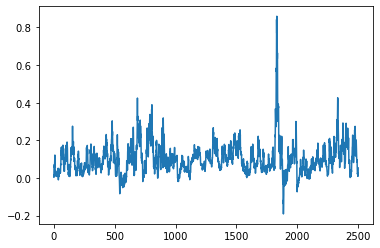

In [12]:
plt.plot(mu
)

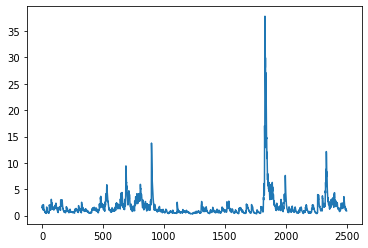

In [11]:
plt.plot(var
)

In [49]:
# fit ARIMA model
from statsmodels.tsa.arima.model import ARIMA


# fit arma model
model = ARIMA(SX5Edata['logreturn'], order=(1,0,1))
arma_model_fit = model.fit()
print(arma_model_fit.summary())

#fir garch model on residuals
residuals = arma_model_fit.resid

garch_model_resid = arch_model(residuals.dropna(), mean='Constant', vol='GARCH', p=1, q=1, rescale=True, dist='t')
garch_model_resid_fit = garch_model_resid.fit()
print(garch_model_resid_fit.summary())

C:\Users\Alberto\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Alberto\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Alberto\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:              logreturn   No. Observations:                 2510
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -4093.547
Date:                Wed, 23 Nov 2022   AIC                           8195.093
Time:                        09:51:43   BIC                           8218.405
Sample:                             0   HQIC                          8203.555
                               - 2510                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0155      0.025      0.611      0.541      -0.034       0.065
ar.L1         -0.3326      0.392     -0.848      0.396      -1.101       0.436
ma.L1          0.3046      0.398      0.765      0.4

In [97]:
#arma_model_fit.fittedvalues
#using brute force
#SX5Edata['armagarch_mean'] = garch_model_resid_fit.params.mu + arma_model_fit.params.const
#garch_model_resid_fit.params.mu + arma_model_fit.params.const + 
print(garch_model_resid_fit.conditional_volatility)
print(arma_model_fit.fittedvalues)
print(garch_model_resid_fit.conditional_volatility + arma_model_fit.fittedvalues)

Date
2012-11-06    0.993122
2012-11-07    0.965727
2012-11-08    1.258890
2012-11-09    1.176042
2012-11-12    1.099896
                ...   
2022-10-31    1.010892
2022-11-01    0.951292
2022-11-02    0.951511
2022-11-03    0.952521
2022-11-04    0.960669
Name: cond_vol, Length: 2501, dtype: float64
Date
2012-11-05    0.015474
2012-11-06    0.015474
2012-11-07   -0.004496
2012-11-08    0.085419
2012-11-09   -0.005434
                ...   
2022-10-31    0.008486
2022-11-01    0.014540
2022-11-02   -0.009563
2022-11-03    0.045835
2022-11-04    0.028999
Length: 2510, dtype: float64
Date
2012-11-05         NaN
2012-11-06    1.008596
2012-11-07    0.961231
2012-11-08    1.344310
2012-11-09    1.170609
                ...   
2022-10-31    1.019378
2022-11-01    0.965832
2022-11-02    0.941948
2022-11-03    0.998356
2022-11-04    0.989668
Length: 2510, dtype: float64


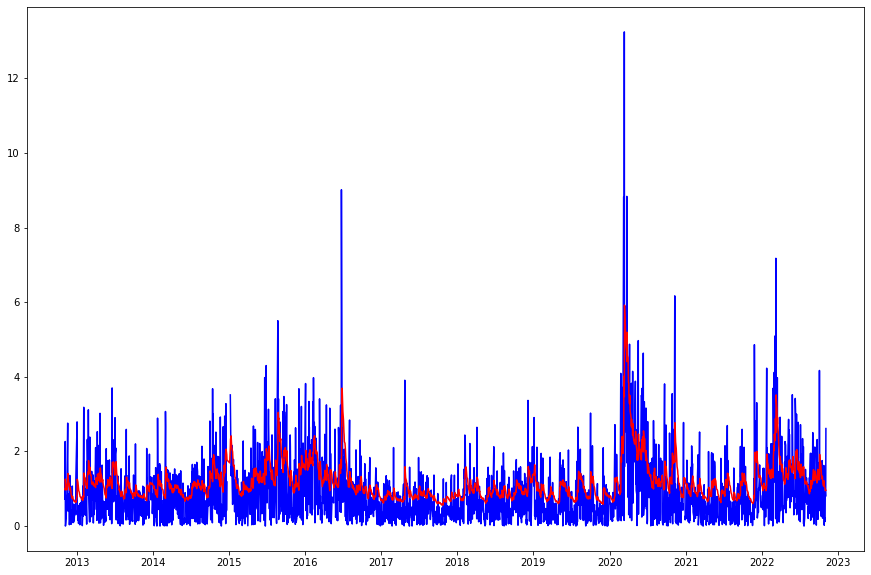

In [107]:
plt.figure(figsize = (15,10))
plt.plot(np.abs(SX5Edata['logreturn']), label='Actual absolute log returns', c="b");
#plt.plot(garch_model_resid_fit.params.mu + arma_model_fit.params.const + garch_model_resid_fit.conditional_volatility + arma_model_fit.fittedvalues, c='y',label='ARMA(1,1)-GARCH(1,1)');
plt.plot(garch_model_resid_fit.conditional_volatility, c='r', label='Volatility process with Garch(1,1)');
plt.show()

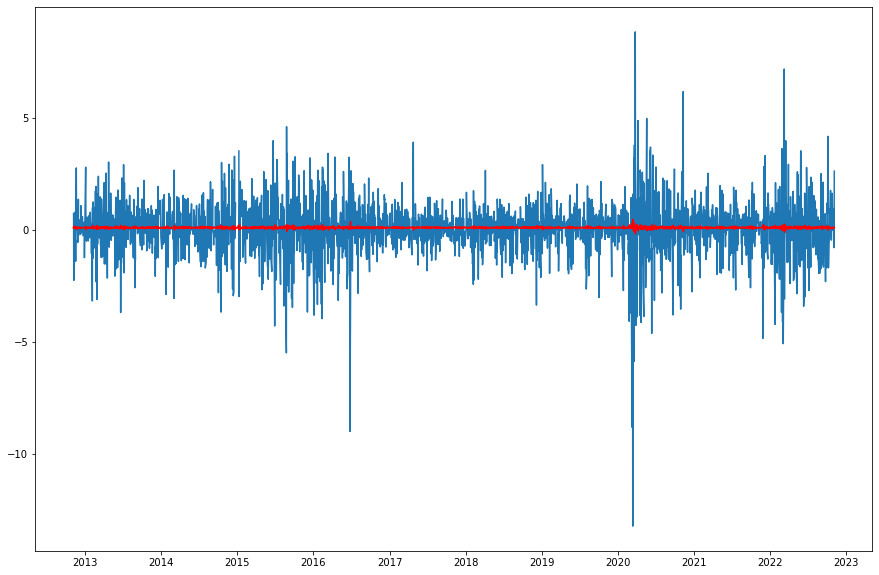

In [99]:
plt.figure(figsize = (15,10))
plt.plot(SX5Edata['logreturn'], label='Actual log returns');
plt.plot( garch_model_resid_fit.params.mu + arma_model_fit.params.const+ arma_model_fit.fittedvalues, c='r');
plt.show()

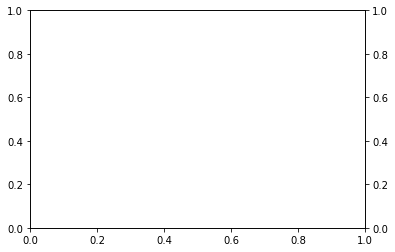

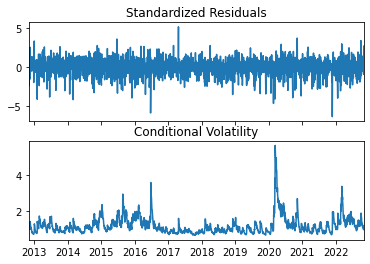

In [67]:
fig, ax3 = plt.subplots()

ax4 = ax3.twinx()

ax1.plot(np.abs(SX5Edata['logreturn'].dropna()), 'r', linewidth=0.5, label='Actual absolute log returns')
ax2.plot(garch_model_resid_fit.conditional_volatility + arma_model_fit.fittedvalues, linewidth=0.5, label='ARMA(1,1)-GARCH(1,1) predicted volatility')

ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1)))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

for label in ax1.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax1.legend(loc=0); ax2.legend(loc=1)
resgarch.plot(); plt.show()

In [127]:
muprocess = np.array([SX5Edata['logreturn'].mean()])
sigmaprocess = np.array([SX5Edata['logreturn'].std()])
xprocess = np.array([SX5Edata['logreturn'].mean()])
for iterator in range(len(SX5Edata['logreturn'])):
    muaux = sol_loglikelihood.x[3] + sol_loglikelihood.x[4]*(xprocess[-1]-sol_loglikelihood.x[3]) + sol_loglikelihood.x[5] *(xprocess[-1] - muprocess[-1])
    sigmaaux = sol_loglikelihood.x[0] + sol_loglikelihood.x[1]*(xprocess[-1]-muprocess[-1])**2 + sol_loglikelihood.x[2]* sigmaprocess[-1]
    xuax = muaux + np.sqrt(sigmaaux)*np.random.standard_t(sol_loglikelihood.x[6])
    muprocess = np.append(muprocess , np.array([muaux]))
    sigmaprocess = np.append(sigmaprocess , np.array([sigmaaux]))
    xprocess = np.append(xprocess , np.array([xuax]))

muprocess = np.delete( muprocess , 0 )
sigmaprocess = np.delete( sigmaprocess , 0 )
xprocess = np.delete( xprocess , 0 )

In [130]:
SX5Edata['predictedq1v'] = xprocess
print(SX5Edata.head(100))

                   SX5E  simplereturn  logreturn  predictedq1v
Date                                                          
2012-11-05  2517.669922           NaN        NaN      0.472237
2012-11-06  2535.939941      0.725672   0.723051      0.135932
2012-11-07  2479.100098     -2.241372  -2.266872     -1.024930
2012-11-08  2479.129883      0.001201   0.001201     -2.209946
2012-11-09  2479.820068      0.027840   0.027836      2.340919
...                 ...           ...        ...           ...
2013-03-26  2641.120117     -0.308005  -0.308480     12.157514
2013-03-27  2612.459961     -1.085152  -1.091082     -5.192929
2013-03-28  2624.020020      0.442497   0.441521     11.898492
2013-04-02  2679.800049      2.125747   2.103468     -7.392104
2013-04-03  2639.010010     -1.522130  -1.533833     -4.182848

[100 rows x 4 columns]


In [119]:
SX5Edata['logreturn'][5]
print(sigmaprocess[-1])

1.2441542517269004


In [ ]:
muprocess = np.array([SX5Edata['logreturn'].mean()])
sigmaprocess = np.array([SX5Edata['logreturn'].std()])
for iterator in range(len(SX5Edata['logreturn'])):
    muaux = sol_loglikelihood.x[3] + sol_loglikelihood.x[4]*(SX5Edata['logreturn'][-1]-sol_loglikelihood.x[3]) + sol_loglikelihood.x[5] *(xprocess[-1] - muprocess[-1])
    sigmaaux = sol_loglikelihood.x[0] + sol_loglikelihood.x[1]*(xprocess[-1]-muprocess[-1])**2 + sol_loglikelihood.x[2]* sigmaprocess[-1]
    xuax = muaux + np.sqrt(sigmaaux)*np.random.standard_t(sol_loglikelihood.x[6])
    muprocess = np.append(muprocess , np.array([muaux]))
    sigmaprocess = np.append(sigmaprocess , np.array([sigmaaux]))
    xprocess = np.append(xprocess , np.array([xuax]))

muprocess = np.delete( muprocess , 0 )
sigmaprocess = np.delete( sigmaprocess , 0 )
xprocess = np.delete( xprocess , 0 )

In [ ]:
def garch11_normal_loglikelihood(alpha0, alpha1, beta1, x):

    var = np.zeros_like(x)

    # We need a proxy for sigma_0^2. Let's take it as the sample variance of the data X
    var[0] = np.var(x, ddof=1)

    # Get all the conditional variance values sigma_t from the GARCH dynamics
    for i in range(1, len(x)):
        var[i] = alpha0 + alpha1 * x[i-1]**2 + beta1 * var[i-1]

    return np.sum(-0.5*np.log(var[1:]) - 0.5 * x[1:]**2 / var[1:] - 0.5*np.log(2*np.pi) ) 

objfun = lambda theta : -1 * garch11_normal_loglikelihood(theta[0]**2, theta[1]**2/(1 + theta[1]**2 + theta[2]**2), theta[2]**2/(1 + theta[1]**2 + theta[2]**2), x)

from scipy.optimize import minimize #import minimize function from SciPy

ini_theta = [1, 1, 1] # Need to supply an initial guess
print("Initial objective function value: " + str(objfun(ini_theta)))

sol = minimize(objfun, ini_theta, method='nelder-mead', options={'xtol': 1e-8, 'disp': True}) # Call the minimiser

# Convert the optimiser in theta back to the original coordinates (alpha0, alpha1, beta1)
alpha0 = sol.x[0]**2
alpha1 = sol.x[1]**2/(1 + sol.x[1]**2 + sol.x[2]**2)
beta1 = sol.x[2]**2/(1 + sol.x[1]**2 + sol.x[2]**2)

print("Estimate of alpha0: " + str(alpha0))
print("Estimate of alpha1: " + str(alpha1))
print("Estimate of beta1: " + str(beta1))

In [156]:
plt.figure(figsize(20,20))
fig, axs = plt.subplots(2,1)
ax1, ax2 = axs

cv = pd.Series(resgarch.conditional_volatility, index=SX5Edata['logreturn'].dropna().index)
ax2.plot(np.abs(SX5Edata['logreturn'].dropna()), 'r-', linewidth=1, label='Observed');
ax2.plot(cv, 'y-', linewidth=1, label=r'$\hat{\sigma}_{t}$');
ax2.set_xlabel('Time')
ax2.set_ylabel('|Log return|')
ax2.legend(prop={'size': 10}); 

plt.show()

NameError: name 'figsize' is not defined